# Introduction

<b> Objective:</b> To understand the basic concepts of ARIMA, SARIMA and SARIMAX in Time Series Forecasting.<br><br>
<b> Concepts: </b>
- ACF, PACF
- Seasonal Decomposition
- Stationarity of time-series
- Auto-ARIMA to choose p,d,q parameters
- ARIMA, SARIMA, SARIMAX
- Evaluation Metrics: RMSE, MSE, Residual Analysis
- Make forecasts for future data points <br>

<b> Definitions: </b>
- ARIMA : Non-seasonal Autoregressive Integrated Moving Averages
- SARIMA : Seasonal ARIMA
- SARIMAX : Seasonal ARIMA with exogenous variables <br>
If a time series, has seasonal patterns, then we need to add seasonal terms and it becomes SARIMA, short for Seasonal ARIMA

## Import Libraries

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tools.eval_measures import rmse
from statsmodels.graphics.tsaplots import month_plot,quarter_plot
from statsmodels.tsa.stattools import adfuller


from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
from dateutil.parser import parse
from scipy import stats
from scipy.stats import normaltest
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

C:\Users\Anfield\anaconda3\lib\site-packages\pmdarima\__init__.py:107: UserWarning: pmdarima support for 32-bit systems is ending with Python 3.10.Your system is not guaranteed to work going forward
  _warnings.warn(


### User-defined function for augmented Dickey-Fuller test

Augmented Dickey-Fuller Test is used to test whether a given time series is stationary or not. The Null and Alternate Hypothesis are: <br>

- Null Hypothesis: Time Series is non-stationary. 
- Alternate Hypothesis: Time Series is stationary.

In [2]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

## Load Data: Airline Passengers Dataset

In [3]:
pwd

'C:\\Users\\Anfield\\Desktop\\Udemy\\TimeSeries\\UDEMY_TSA_FINAL'

In [4]:
df= pd.read_csv(".\\Data\\airline_passengers.csv", index_col="Month", parse_dates= True)
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

# Descriptive Analysis

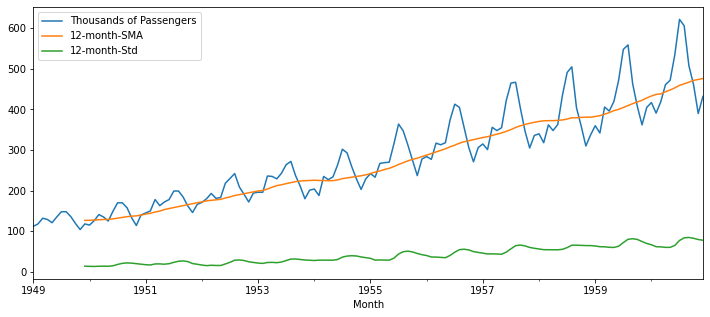

In [6]:
df['12-month-SMA'] = df['Thousands of Passengers'].rolling(window=12).mean()
df['12-month-Std'] = df['Thousands of Passengers'].rolling(window=12).std()

df[['Thousands of Passengers','12-month-SMA','12-month-Std']].plot(figsize=(12,5));

From the above graph, we see that rolling mean itself has a trend component even though rolling standard deviation is fairly constant with time. For our time series to be stationary, we need to ensure that both the rolling statistics ie: mean & std. dev. remain time invariant or constant with time.

In [7]:
df.columns

Index(['Thousands of Passengers', '12-month-SMA', '12-month-Std'], dtype='object')

### Seasonal Decomposition

Statsmodels provides a <em>seasonal decomposition</em> tool we can use to separate out the different components. This lets us see quickly and visually what each component contributes to the overall behavior.


We apply an <strong>additive</strong> model when it seems that the trend is more linear and the seasonality and trend components seem to be constant over time (e.g. every year we add 10,000 passengers).<br>
A <strong>multiplicative</strong> model is more appropriate when we are increasing (or decreasing) at a non-linear rate (e.g. each year we double the amount of passengers).

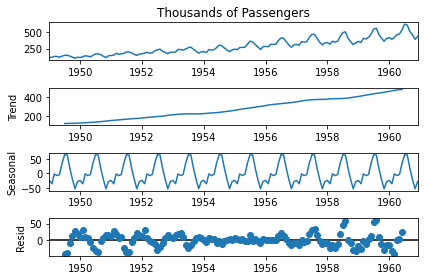

In [8]:
ssn= seasonal_decompose(df["Thousands of Passengers"], model="add")
ssn.plot();

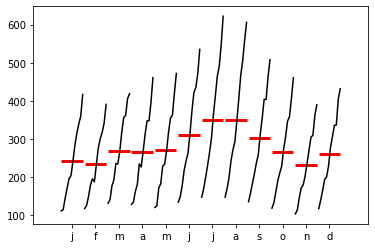

In [9]:
#Exploring Seasonality with Month plots
month_plot(df['Thousands of Passengers']);

### Autocorrelation 

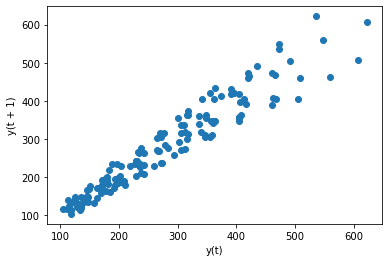

In [10]:
lag_plot(df['Thousands of Passengers']);

This shows very strong autocorrelation; as $y_t$ values increase, nearby (lagged) values also increase.

### ACF and PACF Plots

Just as correlation measures the extent of a linear relationship between two variables, autocorrelation measures the linear relationship between lagged values of a time series.

There are several autocorrelation coefficients, corresponding to each panel in the lag plot. For example, $r_1$ measures the relationship between $y_t$ and $y_{t-1}$, $r_2$ measures the relationship between $y_t$ and $y_{t-2}$ and so on.

- When data have a trend, the autocorrelations for small lags tend to be large and positive because observations nearby in time are also nearby in size. So the ACF of trended time series tend to have positive values that slowly decrease as the lags increase.

- When data are seasonal, the autocorrelations will be larger for the seasonal lags (at multiples of the seasonal frequency) than for other lags.

- When data are both trended and seasonal, you see a combination of these effects.

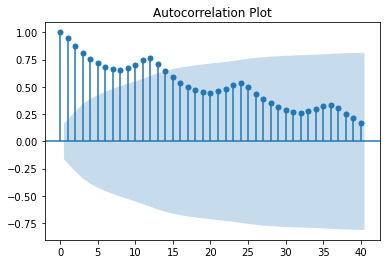

In [11]:
title = 'Autocorrelation Plot'
lags = 40
plot_acf(df["Thousands of Passengers"],title=title,lags=lags);

The ACF plot has lags on the horizontal axis and correlations on the vertical axis. The first value $y_0$ is always 1. <br>
The slow decrease in the ACF as the lags increase is due to the trend, while the “scalloped” shape is due the seasonality.

C:\Users\Anfield\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


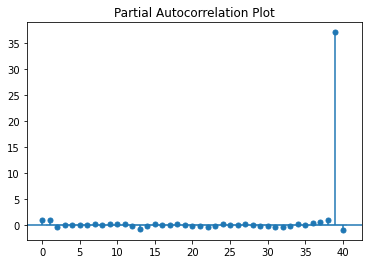

In [12]:
title = 'Partial Autocorrelation Plot'
lags = 40
plot_pacf(df["Thousands of Passengers"],title=title,lags=lags);

The partial autocorrelation at lag k is the autocorrelation between $X_t$ and $X_{t−k}$ that is not accounted for by lags 1 through k−1.
The partial autocorrelation plot can help provide answers to the following questions:
- Is an AR model appropriate for the data?
- If an AR model is appropriate, what order should we use?

## Test for Stationarity

Time series data is said to be <em>stationary</em> if it does <em>not</em> exhibit trends or seasonality. That is, the mean, variance and covariance should be the same for any segment of the series, and are not functions of time.<br>

In [13]:
adf_test(df["Thousands of Passengers"])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.815369
p-value                   0.991880
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


### Some Methods to convert Non-Stationary data to Stationary

#### 1. Stationarity after Regular Differencing

<AxesSubplot:xlabel='Month'>

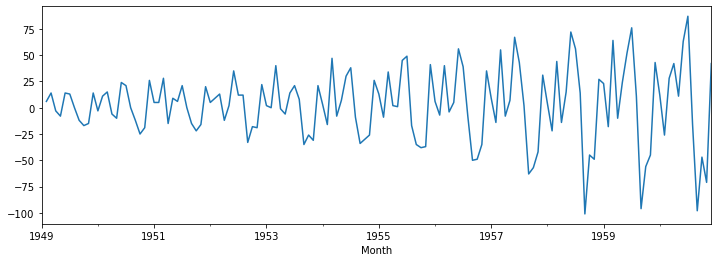

In [14]:
df["difference_1"]= diff(df["Thousands of Passengers"], k_diff=1)
df["difference_1"].plot(figsize=(12,4))

In [15]:
adf_test(df["difference_1"])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.829267
p-value                   0.054213
# lags used              12.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


<AxesSubplot:xlabel='Month'>

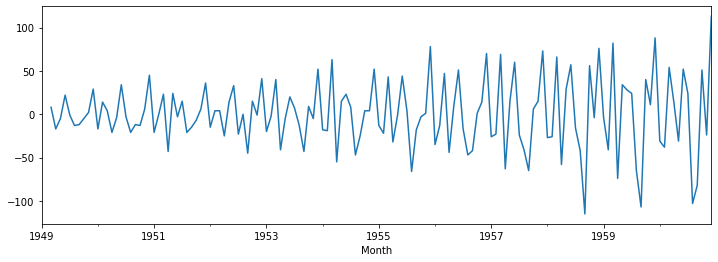

In [16]:
df["difference_2"]= diff(df["Thousands of Passengers"], k_diff=2)
df["difference_2"].plot(figsize=(12,4))

In [17]:
adf_test(df["difference_2"])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.638423e+01
p-value                 2.732892e-29
# lags used             1.100000e+01
# observations          1.300000e+02
critical value (1%)    -3.481682e+00
critical value (5%)    -2.884042e+00
critical value (10%)   -2.578770e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


#### 2. Stationarity after Seasonal Differencing

<AxesSubplot:xlabel='Month'>

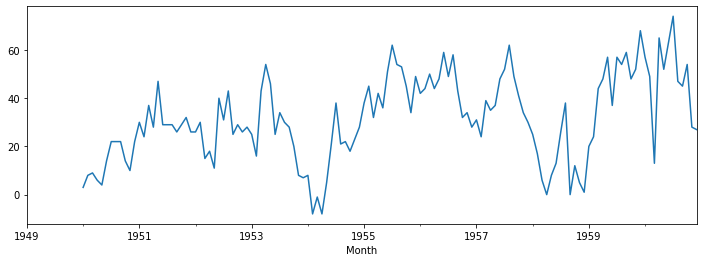

In [18]:
df["difference_seasonal"]= diff(df["Thousands of Passengers"], k_diff=0,k_seasonal_diff= 1,seasonal_periods= 12)
df["difference_seasonal"].plot(figsize=(12,4))

In [19]:
adf_test(df["difference_seasonal"])

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.383021
p-value                   0.011551
# lags used               1.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


#### 3. Box-Cox Transformations

In [20]:
df['Weighted_Price_box'], lmbda = stats.boxcox(df["Thousands of Passengers"])
adf_test(df["Weighted_Price_box"])

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.326071
p-value                   0.617162
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


## train-test split

As a general rule we set the length of test set equal to the intended forecast size. That is, for a monthly dataset you might want to forecast out one more year. Therefore your test set should be one year long.

In [21]:
len(df)

144

In [22]:
train= df.iloc[:len(df)-12]
test= df.iloc[len(df)-12:]

In [23]:
print(len(train))
print(len(test))

132
12


# Fit the model

### Find the order p,d,q

We can find the AR and MA orders (p,q) through ACF and PACF plots (https://people.duke.edu/~rnau/411arim3.htm ,  https://otexts.com/fpp2/non-seasonal-arima.html). But this is a very complicated and time-consuming process. Therefoore, we will use auto_arima() which automates this process. <br> <br>
auto_arima() is like the grid search for time series models. It selects the p,d,q, combination for ARIMA models in a way that aims to minimise the AIC score. <br>
The AIC evaluates a collection of models and estimates the quality of each model relative to the others. Penalties are provided for the number of parameters used in an effort to thwart overfitting. The lower the AIC and BIC, the better the model should be at forecasting.

## 1. seasonal= False (ARIMA)

In [24]:
auto_arima_results= auto_arima(train["Thousands of Passengers"], 
           start_p=0,
           start_q=0,
           max_p=3,
           max_q=3, # maximum p and q
           m=1,              # frequency of series
           d=None,           # let model determine 'd'
           seasonal=False,   # No Seasonality
           start_P=0, 
           D=0,  
           trace=True,
           error_action='ignore',  
           suppress_warnings=True, 
           stepwise=True)

auto_arima_results.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1277.589, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1268.313, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1264.738, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1276.259, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1258.440, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1262.608, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1263.896, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1218.683, Time=0.50 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.85 sec
 A

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -603.341
Date:                Mon, 30 May 2022   AIC                           1218.683
Time:                        19:16:54   BIC                           1235.934
Sample:                             0   HQIC                          1225.692
                                - 132                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7157      0.212      3.379      0.001       0.301       1.131
ar.L1          1.6431      0.028     57.904      0.000       1.587       1.699
ar.L2         -0.9129      0.027    -33.338      0.000      -0.967      -0.859
ma.L1         -1.8478      0.036    -51.463      0.000      -1.918      -1.777
ma.L2          0.9466      0.038     24.988      0.000       0.872       1.021
sigma2       564.8459     67.205      8.405      0.000     433.126     696.566
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):                 1.87
Prob(Q):                              0.36   Prob(JB):                         0.39
Heteroskedasticity (H):               6.40   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Residual Plot in ARIMA model

C:\Users\Anfield\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


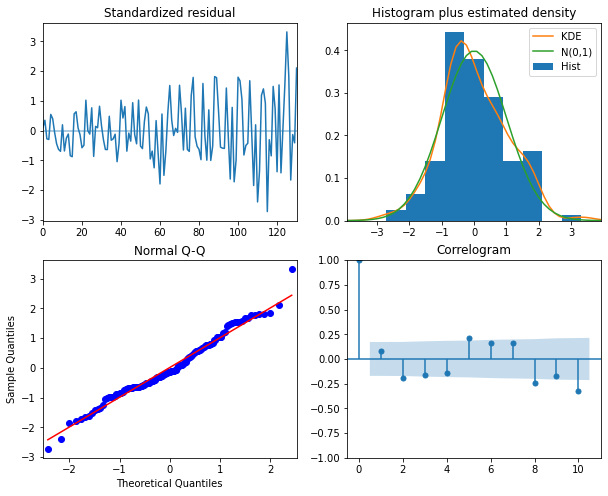

In [25]:
auto_arima_results.plot_diagnostics(figsize=(10,8))
plt.show()

<p>
    <b> Interpretation of plots in plot diagnostics </b>
Standardized residual: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Histogram: The density plot suggest normal distribution with mean slighlty shifted towards right.

Theoretical Quantiles: Mostly the dots fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Correlogram: The Correlogram, (or ACF plot) shows the residual errors are not autocorrelated. The ACF plot would imply that there is some pattern in the residual errors which are not explained in the model. So we will need to look for more X’s (predictors) to the model.
</p>

#### Train ARIMA model using p,d,q values from auto_arima

In [26]:
arima_model= ARIMA(train["Thousands of Passengers"], order= (2,1,2))
arima_model_fit= arima_model.fit()

C:\Users\Anfield\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Anfield\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M

In [27]:
normaltest(arima_model_fit.resid)
# If p value is not less than 0.05, that means Residuals are normally distributed

NormaltestResult(statistic=2.1923024730988345, pvalue=0.3341546943311093)

### Make predictions on test

In [28]:
start= len(train)
end= len(train) + len(test) -1

pred= arima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("ARIMA predictions")

<AxesSubplot:title={'center':'Actual v/s Predictions for Test dataset'}, xlabel='Month'>

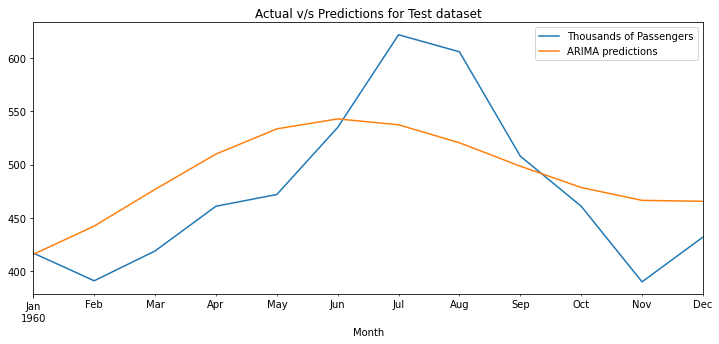

In [29]:
title= "Actual v/s Predictions for Test dataset"
test["Thousands of Passengers"].plot(figsize=(12,5), title= title, legend=True);
pred.plot(legend=True)


### Evaluate the Model

In [30]:
mse= mean_squared_error(test["Thousands of Passengers"],pred)
rmse_arima= rmse(test["Thousands of Passengers"], pred)

print(f"Root Mean Square is {rmse_arima} \n")
print(f"Mean Square Error is {mse}")

Root Mean Square is 53.28852926085563 

Mean Square Error is 2839.667350785067


## 2. seasonal = True (SARIMA Model)

- ARIMA models do not support seasonality.
- If the time series has defined seasonality, then we should go for Seasonal ARIMA model (SARIMA) which uses seasonal differencing.
- Seasonal differencing is similar to regular differencing, but, instead of subtracting consecutive terms, we subtract the value from previous season.
- So, the model will be represented as SARIMA(p,d,q)x(P,D,Q), where, P, D and Q are SAR, order of seasonal differencing and SMA terms respectively and 'x' is the frequency of the time series. 
- Set seasonal= True and frequency m=12 for month wise series

In [31]:
smodel = auto_arima(train["Thousands of Passengers"],
                    start_p=0,
                    start_q=0,
                    max_p=3,
                    max_q=3, 
                    m=12,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1022.029, Time=0.36 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=0.56 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=0.55 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.14 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=1.30 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.65 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=0.63 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=907.060, Time=3.95 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=0.39 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=0.77 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.19 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.713, Time=0.56 sec
 ARIMA(2,0,0)(1,1,1)[12] intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(3, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -447.843
Date:                            Mon, 30 May 2022   AIC                            905.686
Time:                                    19:17:32   BIC                            919.623
Sample:                                         0   HQIC                           911.346
                                            - 132                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.5341      2.007      2.757      0.006       1.600       9.468
ar.L1          0.7049      0.095      7.393      0.000       0.518       0.892
ar.L2          0.2574      0.131      1.968      0.049       0.001       0.514
ar.L3         -0.1434      0.107     -1.338      0.181      -0.354       0.067
sigma2       101.0969     12.818      7.887      0.000      75.974     126.220
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.83
Prob(Q):                              0.96   Prob(JB):                         0.24
Heteroskedasticity (H):               1.41   Skew:                            -0.14
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Anfield\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anfield\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Root Mean Square is 17.815601565728684 

Mean Square Error is 317.3956591487943


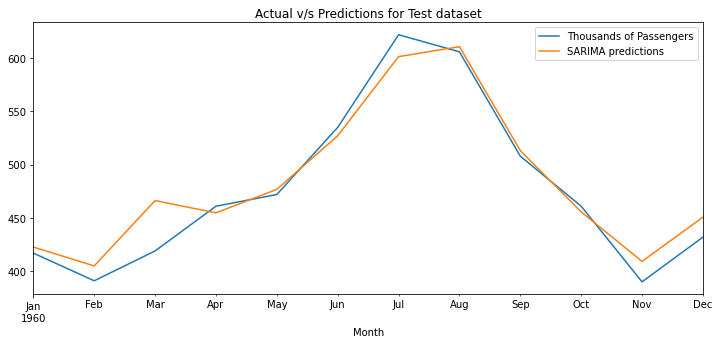

In [34]:
sarima_model= SARIMAX(train["Thousands of Passengers"], order= (3,0,0), seasonal_order= (0,1,0,12))
sarima_model_fit= sarima_model.fit()

#Make predictions on Test
start= len(train)
end= len(train) + len(test) -1
pred= sarima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("SARIMA predictions")

#Plot the predictions on Test
title= "Actual v/s Predictions for Test dataset"
test["Thousands of Passengers"].plot(figsize=(12,5), title= title, legend=True)
pred.plot(legend=True)


#Evaluate the model
mse= mean_squared_error(test["Thousands of Passengers"],pred)
rmse_sarima= rmse(test["Thousands of Passengers"], pred)

print(f"Root Mean Square is {rmse_sarima} \n")
print(f"Mean Square Error is {mse}")

## 3. SARIMA with Exogenous Variable (SARIMAX)

- Now, we will force an external predictor, also called, exogenous variable into the model. This model is called the SARIMAX model. The only requirement to use an exogenous variable is we should know the value of the variable during the forecast period as well.
- I want to see how the model looks if we force the recent seasonality pattern into the training and forecast. The seasonal index is a good exogenous variable because it repeats every frequency cycle, 12 months in this case.
- So, we will always know what values the seasonal index will hold for the future forecasts.
- Let’s compute the seasonal index so that it can be forced as a (exogenous) predictor to the SARIMAX model


In [35]:
# Compute Seasonal Index
# multiplicative seasonal component
result_mul = seasonal_decompose(train['Thousands of Passengers'],   # 3 years
                                model='multiplicative', 
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# merge with the Train data
train['month'] = train.index.month
train2 = pd.merge(train, seasonal_index, how='left', on='month')
train2.index = train.index  # reassign the index


# merge with the Test data
test['month'] = test.index.month
test2 = pd.merge(test, seasonal_index, how='left', on='month')
test2.index = test.index  # reassign the index

C:\Users\Anfield\AppData\Local\Temp/ipykernel_7948/860633038.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['month'] = train.index.month
C:\Users\Anfield\AppData\Local\Temp/ipykernel_7948/860633038.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['month'] = test.index.month


In [36]:
# SARIMAX Model
sxmodel = auto_arima(train2["Thousands of Passengers"],
                     exogenous=train2[['seasonal']],
                    start_p=0,
                    start_q=0,
                    max_p=3,
                    max_q=3, 
                    m=12,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1039.277, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1091.636, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1002.812, Time=0.59 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1040.664, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1092.492, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1089.467, Time=0.17 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1004.800, Time=1.48 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1004.804, Time=0.79 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1040.617, Time=0.34 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=2.93 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1003.978, Time=0.53 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=1004.130, Time=0.81 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1003.642, Time=1.00 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1003.171, Time=0.88 sec
 ARIMA(2,1,1)(1,0,0)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -496.718
Date:                            Mon, 30 May 2022   AIC                           1001.435
Time:                                    19:18:19   BIC                           1012.936
Sample:                                01-01-1949   HQIC                          1006.108
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
seasonal     286.1955     31.027      9.224      0.000     225.383     347.008
ar.L1         -0.1635      0.094     -1.741      0.082      -0.348       0.021
ar.S.L12       0.8303      0.058     14.330      0.000       0.717       0.944
sigma2       103.3701     12.564      8.227      0.000      78.745     127.995
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.47
Prob(Q):                              0.96   Prob(JB):                         0.11
Heteroskedasticity (H):               1.70   Skew:                            -0.24
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Anfield\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anfield\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Root Mean Square is 20.540662050654742 

Mean Square Error is 421.9187974792078


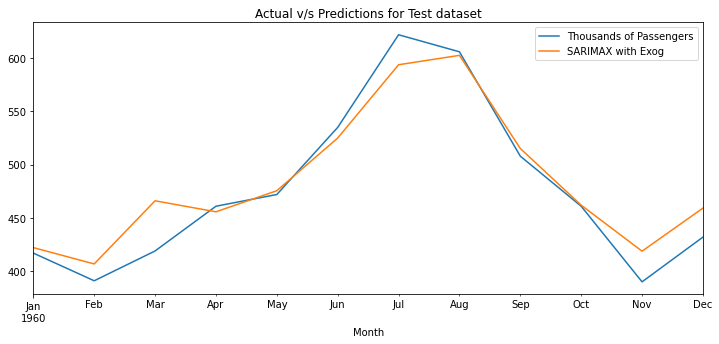

In [38]:
sarimax_model= SARIMAX(train2["Thousands of Passengers"], order= (1,1,0), seasonal_order= (1,0,0,12),exog=train2[['seasonal']])
sarimax_model_fit= sarimax_model.fit()

#Predict on Test
start= len(train)
end= len(train) + len(test) -1
pred= sarimax_model_fit.predict(start=start, end=end, dynamic=False, typ="levels",exog=test2[['seasonal']]).rename("SARIMAX with Exog")

#Plot predictions on Test
title= "Actual v/s Predictions for Test dataset"
test["Thousands of Passengers"].plot(figsize=(12,5), title= title, legend=True)
pred.plot(legend=True)

#Evaluate the model
mse= mean_squared_error(test["Thousands of Passengers"],pred)
rmse_sarimax= rmse(test["Thousands of Passengers"], pred)

print(f"Root Mean Square is {rmse_sarimax} \n")
print(f"Mean Square Error is {mse}")

We see that out of the 3 models we created (ARIMA, SARIMA, SARIMAX), SARIMAX generated the best predictions. Hence we will use this model to generate forecasts for future datapoints

# Re-train SARIMA Model on entire data and make future forecasts

In [39]:
model= SARIMAX(df["Thousands of Passengers"], order= (3,0,0), seasonal_order= (0,1,0,12))
results= model.fit()

start= len(df)
end= len(df) + len(test) -1

pred= results.predict(start=start, end=end, dynamic=False, typ="levels").rename("Future Forecasts")

C:\Users\Anfield\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anfield\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


### Plot the Forecasts

<AxesSubplot:title={'center':'Current observations and Future forecasts'}, xlabel='Month'>

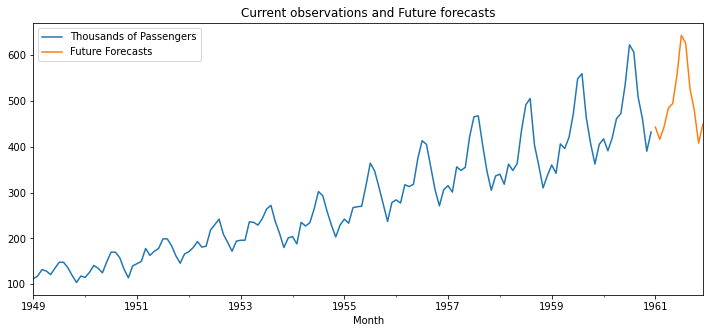

In [40]:
title= "Current observations and Future forecasts"
df["Thousands of Passengers"].plot(figsize=(12,5), title= title, legend=True)
pred.plot(legend=True)

## References

<p>
https://www.kaggle.com/code/prashant111/arima-model-for-time-series-forecasting <br>
https://www.udemy.com/course/python-for-time-series-data-analysis/ <br>
https://otexts.com/fpp2/autocorrelation.html <br>
https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4463.htm <br>
</p>